# Implement of Expectation Propagation

EPアルゴリズムの実装と使用例

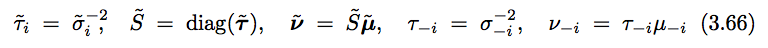

In [139]:
Image(filename='366.png', width=700)

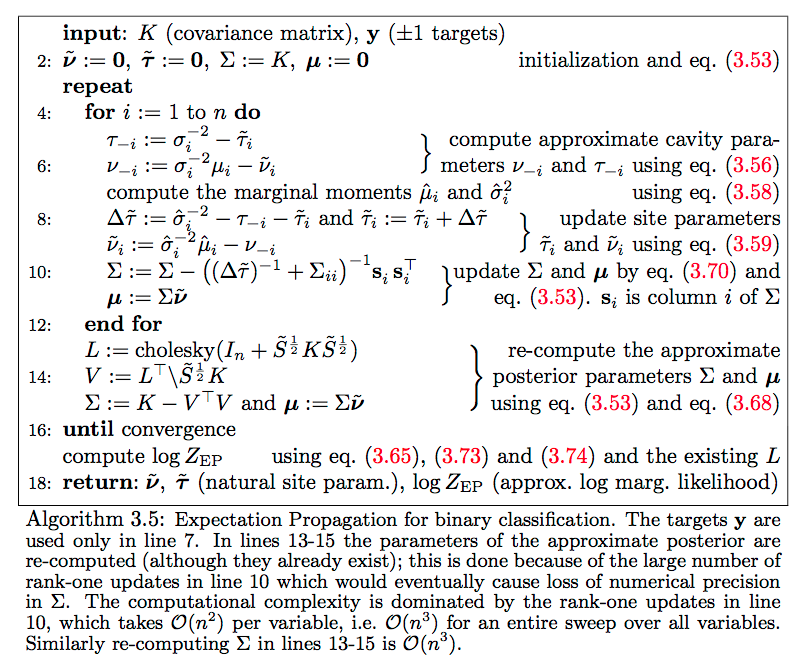

In [180]:
Image(filename='alg35.png', width=700)

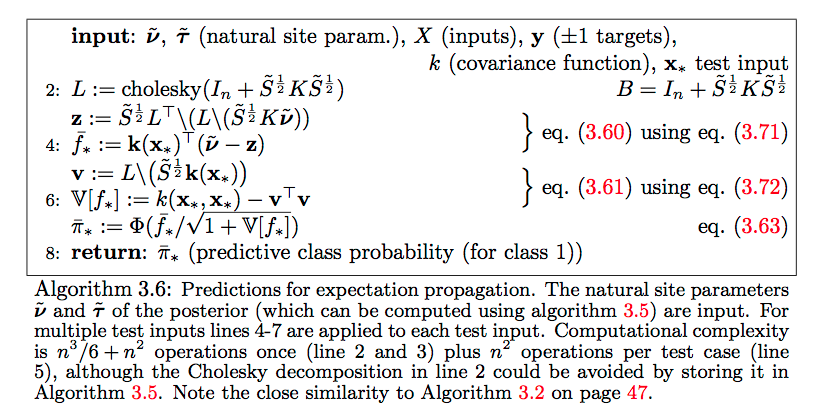

In [181]:
Image(filename='alg36.png', width=700)

In [20]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import Image
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
class EP:
    
    def __init__(self, n):        
        self.sigma_tilde = np.ones((n, 1))
        self.tau_tilde = 1.0 / self.sigma_tilde
        self.S_tilde = np.diag(self.tau_tilde.reshape(-1))
        self.mu_tilde = np.ones((n, 1))
        self.nu_tilde = self.S_tilde @ self.mu_tilde
        
    def fit(self, K, y, n_iter=100):
        Sigma = K
        mu = np.zeros((len(y), 1))
        for j in range(n_iter):
            for i in range(len(y)):
                
                # eq. (3.56)
                tau_cavity = 1.0 / Sigma[i, i] - self.tau_tilde[i, 0]
                nu_cavity = mu[i, 0] / Sigma[i, i] - self.nu_tilde[i, 0]
                mu_cavity = nu_cavity / tau_cavity
                sigma_cavity = 1.0 / tau_cavity
                
                # eq. (3.58)
                zi = y[i, 0] *  mu_cavity / np.sqrt(1.0 + sigma_cavity)
                Zi_hat = 1.0 / (1.0 + np.exp(-zi))
                nd = np.exp(- 0.5 * zi**2) / np.sqrt(2.0 * np.pi)
                mu_hat = mu_cavity + (y[i, 0] * sigma_cavity * nd) / (Zi_hat * np.sqrt(1.0 + sigma_cavity))
                sigma_hat = sigma_cavity - sigma_cavity**2 * nd * (zi + nd / Zi_hat) / (1.0 + sigma_cavity) / Zi_hat
                
                # eq. (3.59)
                delta_tau = 1.0 / sigma_hat - tau_cavity - self.tau_tilde[i, 0]
                self.tau_tilde[i, 0] = self.tau_tilde[i, 0] + delta_tau
                self.nu_tilde[i, 0] = 1.0 / sigma_hat * mu_hat - nu_cavity
                
                # eq. (3.53), (3.70)
                si = Sigma[:, i]
                Sigma = Sigma - (1.0 / (1.0 / delta_tau + Sigma[i, i])) * si @ si.T
                mu = Sigma @ self.nu_tilde
                
            # eq. (3.53), (3.68)
            S_root = self.S_tilde**0.5
            L = la.cholesky(np.eye(len(y)) + S_root @ K @ S_root)
            V = la.solve(L.T, S_root) @ K
            Sigma = K - V.T @ V
            mu = Sigma @ self.nu_tilde
            
        return(self.nu_tilde, self.tau_tilde)
        
    def predict(self, X, K, y, k, x_test):
        S_root = self.S_tilde**0.5
        L = la.cholesky(np.eye(len(y)) + S_root @ K @ S_root)
        
        # eq. (3.60)
        z = S_root @ (la.solve(L.T, (la.solve(L, S_root @ K @ self.nu_tilde))))
        kx = np.array([k(X[:, i], x_test) for i in range(X.shape[1])]).reshape(-1, 1)
        f_bar_test = kx.T @ (self.nu_tilde - z)
        
        # eq. (3.61)
        v = la.solve(L, S_root @ kx)
        var_f_test = k(x_test, x_test) - v.T @ v
        
        # eq. (3.63)
        pi_bar_test = 1.0 / (1.0 + np.exp(-(f_bar_test / np.sqrt(1 + var_f_test))))
        
        return pi_bar_test

In [194]:
## classification by using EP

# The squared  exponential covariance function k(x, x')
sigmaf2 = 2500.0
l2 = 8.0
k = lambda x, x_dash: sigmaf2 * np.exp(-0.5 * (la.norm(x - x_dash))**2 / l2)

# iris dataset(only 2 class)
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

y = np.array(iris.target[iris.target != 2])
y[y == 0] = -1
y = y.reshape(-1, 1)
n = y.shape[0]
x = df.ix[:n - 1, [0, 2]]
K = np.array([[k(x.ix[i], x.ix[j]) for i in range(n)] for j in range(n)])

In [ ]:
ep = EP(n=n)
ep.fit(K=K, y=y)
ep.predict(X=x.T.values, K=K, y=y, k=k, x_test=x.ix[0].reshape(-1, 1))

In [186]:
K

array([[ 2500.        ,  2493.75780599,  2473.57811483, ...,
         1370.31512532,  2130.35947242,  1549.86174763],
       [ 2493.75780599,  2500.        ,  2492.19969433, ...,
         1329.81619292,  2125.04022556,  1522.97511128],
       [ 2473.57811483,  2492.19969433,  2500.        , ...,
         1237.58974232,  2066.10611492,  1438.7730933 ],
       ..., 
       [ 1370.31512532,  1329.81619292,  1237.58974232, ...,
         2500.        ,  2085.56693983,  2455.09567476],
       [ 2130.35947242,  2125.04022556,  2066.10611492, ...,
         2085.56693983,  2500.        ,  2266.33894931],
       [ 1549.86174763,  1522.97511128,  1438.7730933 , ...,
         2455.09567476,  2266.33894931,  2500.        ]])

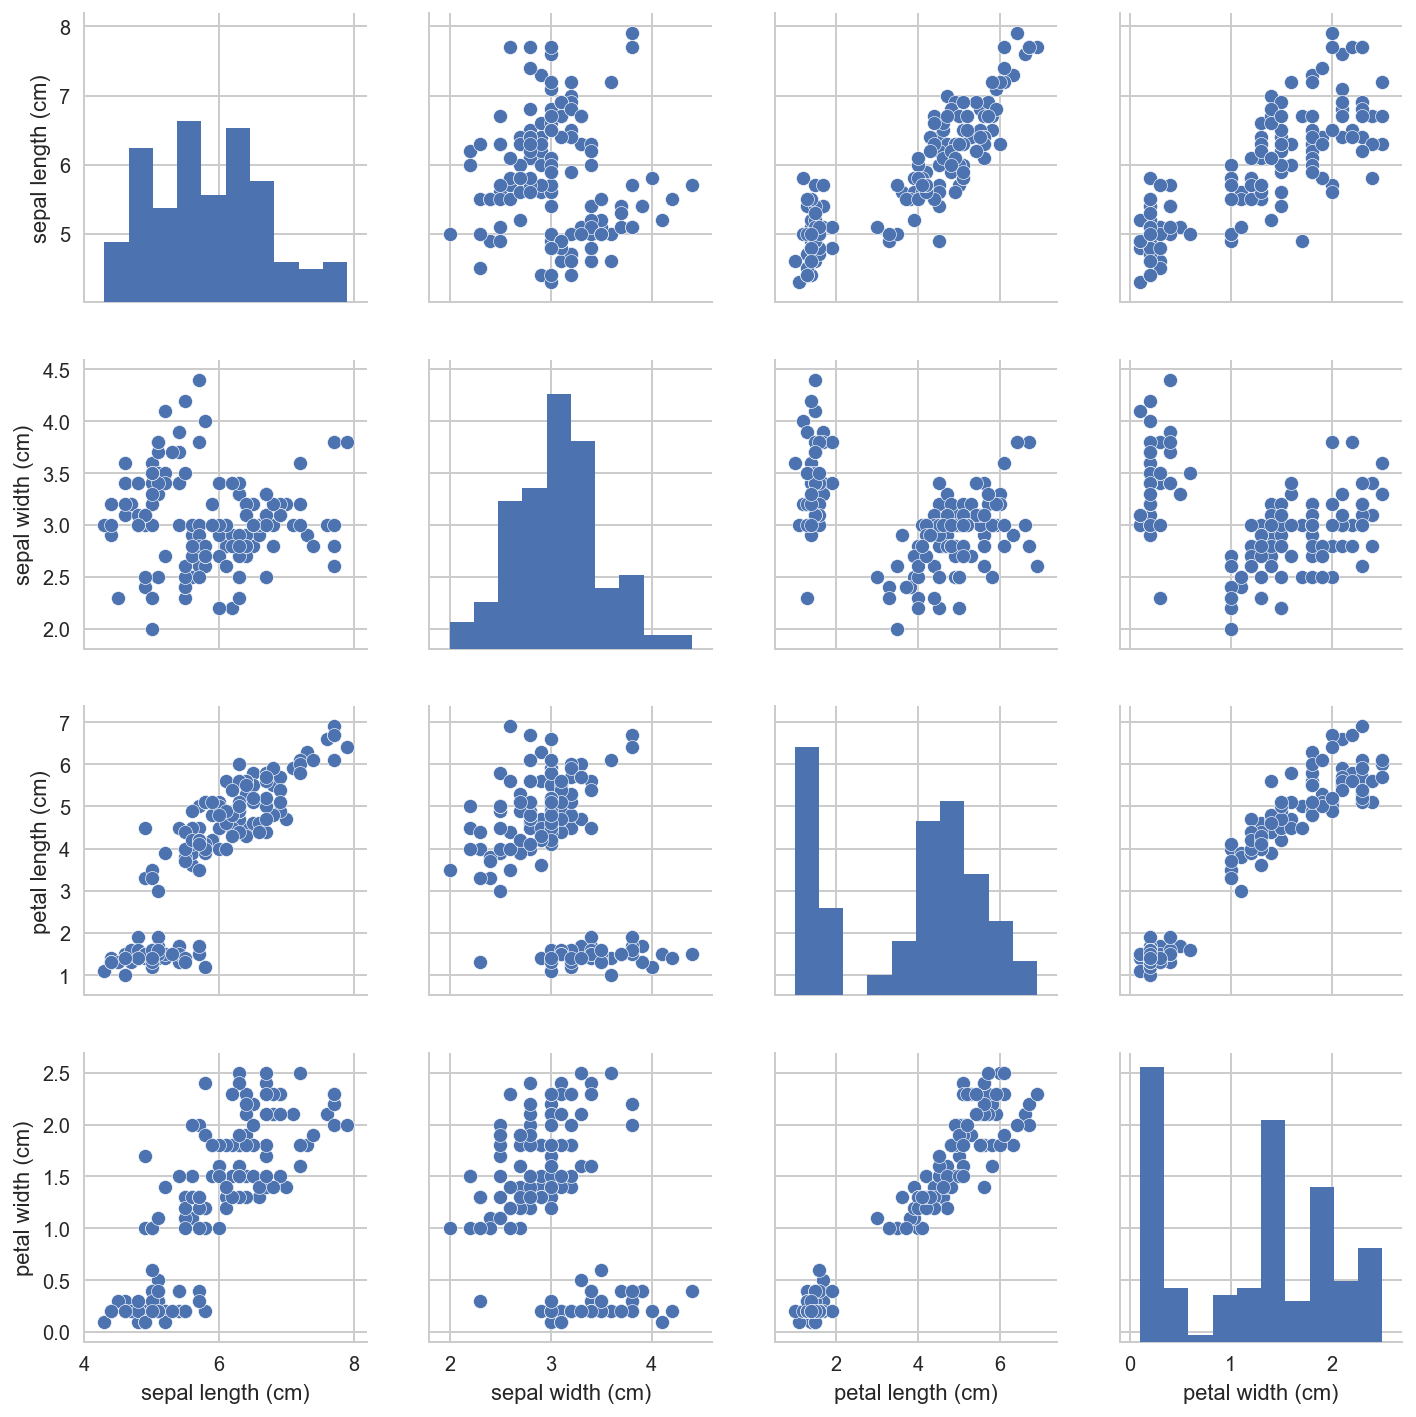

In [104]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)

sns.set(style='whitegrid', context='notebook')

sns.pairplot(df, size=2.5)
plt.tight_layout()
plt.show()

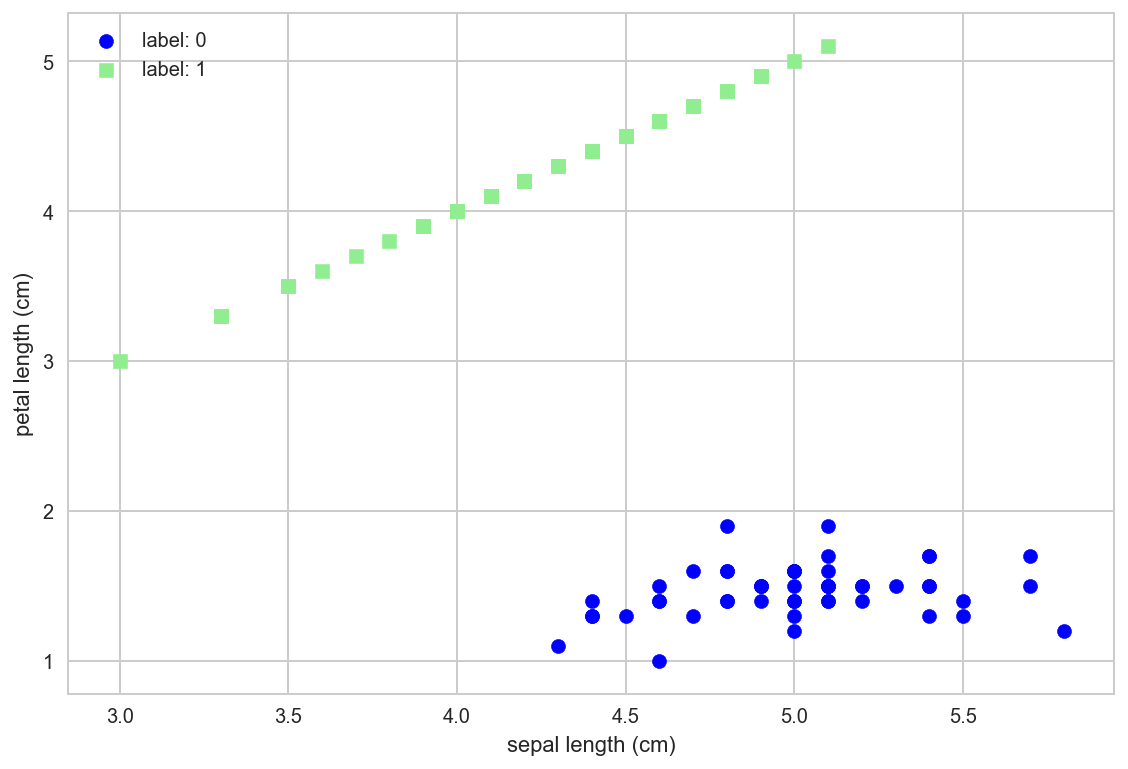

In [140]:
x0 = x[iris.target[iris.target != 2] == 0].values
x1 = x[iris.target[iris.target != 2] == 1].values

plt.scatter(x0[:, 0], x0[:, 1],
            c='blue', marker='o', label='label: 0')
plt.scatter(x1[:, 1], x1[:, 1],
            c='lightgreen', marker='s', label='label: 1')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()